# MazeDrone with TF Agents - 19 Train and Save Checkpoint 2


In [1]:
from __future__ import absolute_import, division, print_function

import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'




import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

from resources import build_agent, TrainingSession
import pandas as pd
import gc

2024-10-28 16:56:22.204572: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 16:56:22.209539: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 16:56:22.288190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 16:56:23.478872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# if len(sys.argv) != 4:
#     print("Usage: X Y Z -> X = Combination | Y = Min Run | Z = Max Run")
#     return -1

# min_combination = int(sys.argv[1])
# min_run = int(sys.argv[2])
# max_run = int(sys.argv[3])

min_combination = 2
min_run = 1
max_run = 1

num_iterations = 7_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

# Agent fully connected layer params 
fc_layer_params = (200,) 

# File's name
description = "19"

maze_size = 3

rewards = []
rewards.append({
    'destroyed': -10.,
    'stuck': - 6.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -15.,
    'reached': 10.,
    'standard': -1.
})


sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)





# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env)
agent.initialize()

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[0], agent, collect_steps_per_iteration, 
                        1, eval_interval, replay_buffer_max_length, num_eval_episodes)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, _, replay_buffer, _ = session.train()

# CLEAR MEMORY
del(session)



print("============================================================== After first training:")

print(agent.train_step_counter)

checkpoint_dir = './checkpoint/phase-1-crash'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)

print(agent.train_step_counter)


train_checkpointer.initialize_or_restore()
    
print(agent.train_step_counter)

agent._optimizer.learning_rate = learning_rate
print(agent._optimizer.learning_rate)

Rewards Updated: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Mode set: 1
Mode set: 1
Maze site set: 3x3
Maze site set: 3x3
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Rewards: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
============================================================== After first training:
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>
<tf.Va

In [3]:
print("========================================================================== Training:")


for combination in range(min_combination-1, min_combination):

    for run in range(min_run-1, max_run):
        print('Combination', combination + 1, ' | Run', run + 1)
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            policy=agent.policy,
            replay_buffer=replay_buffer,
            global_step=agent.train_step_counter
        )
        agent._optimizer.learning_rate = learning_rate
        print(agent.train_step_counter)


        # GENERATE TRAINING SESSION
        session = TrainingSession(description, maze_size, env_name, rewards[combination], agent, collect_steps_per_iteration, 
                                num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes)
        
        # TRAINING
        step_log, returns, finished, crashed, stucked, steped, log_loss, replay_buffer, agent = session.train(without_wall_training=True, early_stop="stuck")

        # LOGGING
        df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})
        df_log.to_csv(f"logs/02-stuck-improving/{description}_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)

        # CLEAR MEMORY
        #del(agent)
        # del(session)
        # del(df_log)
        # gc.collect()


========================================================================== Training:
Combination 2  | Run 1
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>
Rewards Updated: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Mode set: 1
Mode set: 1
Maze site set: 3x3
Maze site set: 3x3
Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Early stop counter: 1
Early stop counter: 2
Early stop counter: 3
Early stop counter: 4
step = 3000
Early stop reseted at 3000
Early stop counter: 1
Early stop counter: 2
Early stop counter: 3
Early stop counter: 4
Early stop counter: 5
Early stop at 3500
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


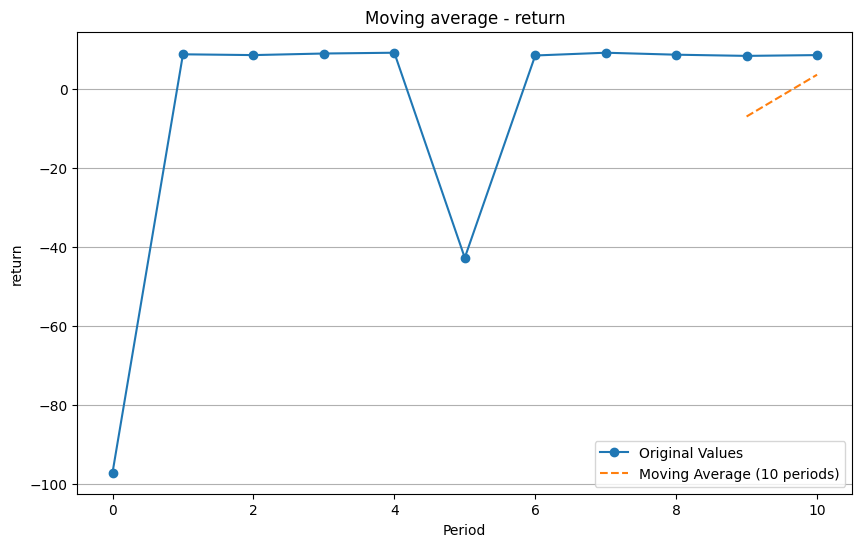

In [4]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

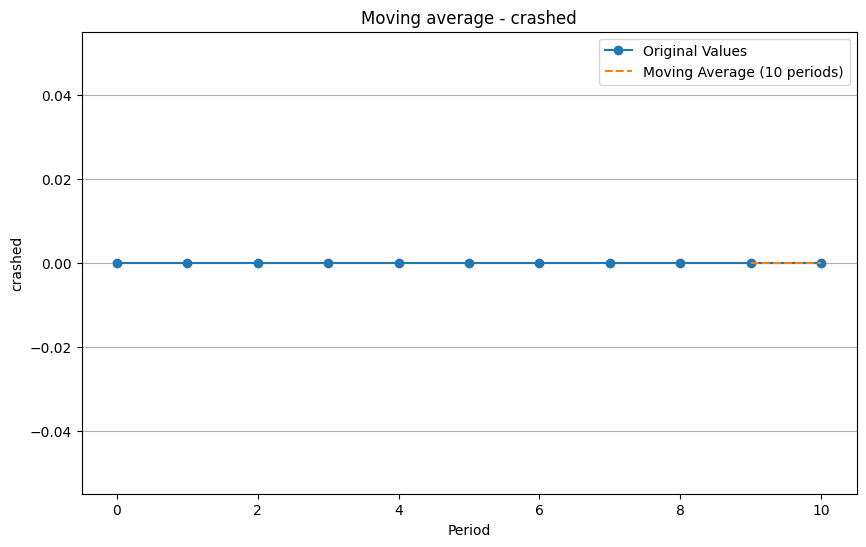

In [5]:
plot_moving_avg('crashed', crashed)

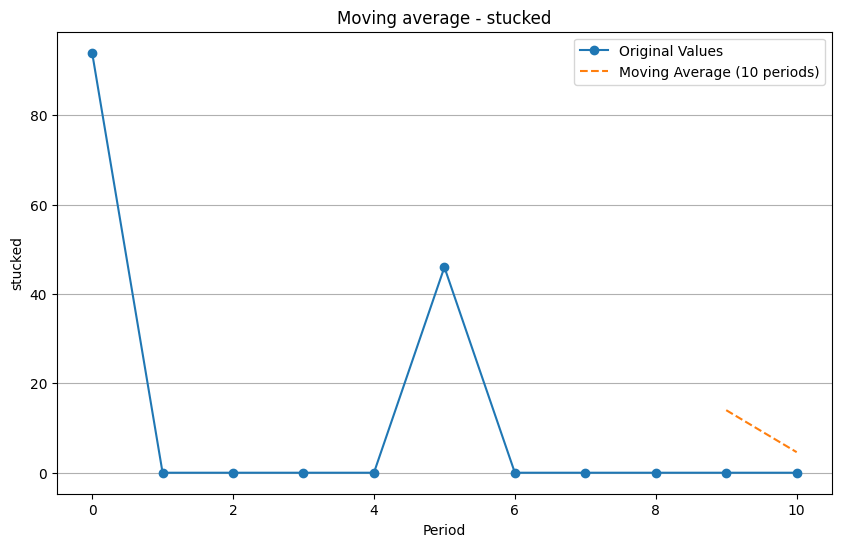

In [6]:
plot_moving_avg('stucked', stucked)

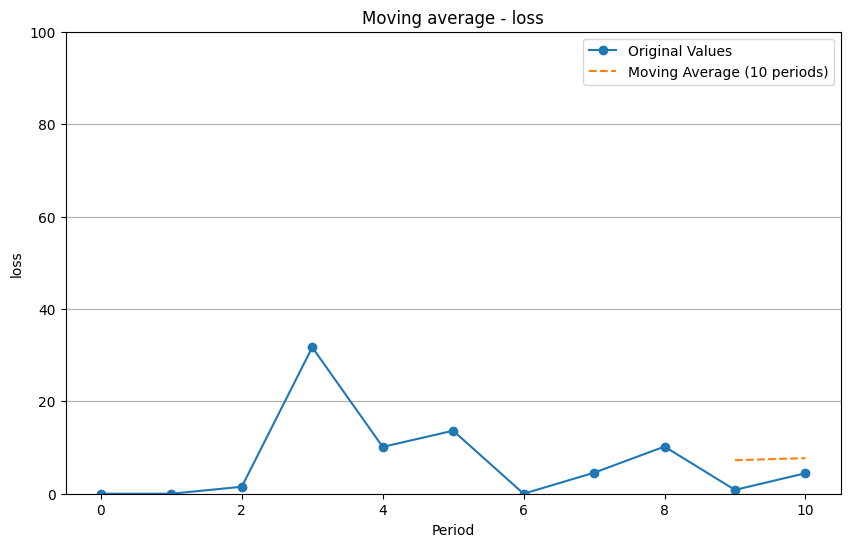

In [7]:
plot_moving_avg('loss', log_loss, ylim=True, top_lim=1_00)

In [9]:
checkpoint_dir = './checkpoint/phase-2-stuck'

train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)


In [10]:
train_checkpointer.save(agent.train_step_counter)

In [8]:
agent

In [11]:
agent.train_step_counter

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=3500>

In [12]:
from resources import create_policy_eval_video


# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)
train_py_env.set_size(maze_size)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent-{description}", train_env, train_py_env)

Mode set: 1
Maze site set: 3x3
